<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/Moderate_STL_10__DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import utils
from skimage.metrics import structural_similarity as ssim
import math
import cv2
import time
import os

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device


In [3]:
# Define Loss function
def mse_loss(input, target):
    r = input[:,0:1,:,:] - target[:,0:1,:,:]
    g = (input[:,1:2,:,:] - target[:,1:2,:,:])
    b = input[:,2:3,:,:] - target[:,2:3,:,:]
    
    r = torch.mean(r**2)
    g = torch.mean(g**2)
    b = torch.mean(b**2)
    
    mean = (r + g + b)/3
   
    return mean

In [4]:
def Get_psnr(input, output, max_val=1.0):
    input = input.cpu().detach().numpy()
    output = output.cpu().detach().numpy()

    b = input[:,:,0]
    g = input[:,:,1]
    r = input[:,:,2]

    hat_b = output[:,:,0]
    hat_g = output[:,:,1]
    hat_r = output[:,:,2]

    b_img_diff = hat_b - b
    g_img_diff = hat_g - g 
    r_img_diff = hat_r - r
    
    b_mse = np.mean(b_img_diff**2)
    g_mse = np.mean(g_img_diff**2)
    r_mse = np.mean(r_img_diff**2)

    total_mse = r_mse + g_mse + b_mse
    

    if total_mse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/total_mse)
      return psnr 

In [5]:
batch_size = 16
torch.manual_seed(1)
torch.cuda.manual_seed(1)


In [6]:
# 훈련 데이터, 검증 데이터, 테스트 데이터순으로 80,000, 20,000, 8,000

tr_set = datasets.STL10(root = "./data", split = "unlabeled", transform = transforms.ToTensor(), download=True)

Files already downloaded and verified


In [7]:
tr_subset, val_subset = torch.utils.data.random_split(tr_set,[80000,20000],generator=torch.Generator().manual_seed(1))

test_set = datasets.STL10(root = "./data", split = "test", transform = transforms.ToTensor(), download=True)

Files already downloaded and verified


In [8]:
tr_dataloader = DataLoader(tr_subset, batch_size = batch_size, num_workers = 4)
val_dataloader = DataLoader(val_subset, batch_size = batch_size, num_workers = 4)
test_dataloader = DataLoader(test_set, batch_size = batch_size, num_workers = 4)

In [9]:
print(len(tr_subset),len(val_subset), len(test_set))

80000 20000 8000


In [10]:
img_train_set = tr_subset.dataset.data[tr_subset.indices]
label_train_set = tr_subset.dataset.labels[tr_subset.indices]

img_val_set = val_subset.dataset.data[val_subset.indices]
label_val_set = val_subset.dataset.labels[val_subset.indices]

img_test_set = test_set.data
label_test_set = test_set.labels

In [11]:
img_val_set.shape

(20000, 3, 96, 96)

In [12]:
label_val_set #No Label

array([-1, -1, -1, ..., -1, -1, -1])

In [13]:
img_test_set.shape

(8000, 3, 96, 96)

In [14]:
label_test_set

array([6, 7, 5, ..., 8, 8, 8], dtype=uint8)

In [15]:
label_test_set
img_test_set

array([[[[227, 227, 226, ..., 229, 228, 229],
         [227, 226, 228, ..., 228, 229, 228],
         [227, 227, 227, ..., 228, 229, 229],
         ...,
         [222, 227, 231, ..., 170, 196, 199],
         [233, 213, 202, ..., 203, 206, 194],
         [224, 225, 224, ..., 196, 179, 174]],

        [[235, 235, 236, ..., 233, 234, 235],
         [235, 235, 235, ..., 233, 233, 234],
         [235, 236, 236, ..., 233, 233, 233],
         ...,
         [174, 184, 186, ..., 147, 163, 167],
         [192, 174, 163, ..., 168, 167, 158],
         [181, 184, 184, ..., 153, 146, 138]],

        [[237, 237, 237, ..., 236, 236, 235],
         [237, 237, 237, ..., 236, 236, 234],
         [237, 236, 235, ..., 236, 236, 235],
         ...,
         [115, 119, 120, ..., 114, 122, 135],
         [133, 121, 109, ..., 126, 121, 114],
         [131, 130, 134, ..., 104, 107, 101]]],


       [[[ 86, 100, 104, ..., 114, 118, 116],
         [ 82,  92, 102, ..., 109, 119, 119],
         [ 74,  86,  96, ..., 

In [16]:
img_train_set_arr = np.array(img_train_set)
img_val_set_arr = np.array(img_val_set)
img_test_set_arr = np.array(img_test_set)

In [17]:
print(len(tr_subset))

80000


In [18]:
Gs_blur_moderate_tr_dataset = []
for i in range(80000):
  hat_img_train_set_arr = cv2.GaussianBlur(img_train_set_arr[i], (21,21),0)
  hat_img_train_set_tensor_byte = torch.from_numpy(hat_img_train_set_arr)
  hat_img_train_set_tensor_float = hat_img_train_set_tensor_byte.float()
  hat_img_train_set_tensor_normal = hat_img_train_set_tensor_float.div(255.0)
  Gs_blur_moderate_tr_dataset.append([hat_img_train_set_tensor_normal,0])

In [19]:
Gs_blur_moderate_val_dataset = []
for j in range(10000):
  hat_img_val_set_arr = cv2.GaussianBlur(img_val_set_arr[j],  (21,21),0)
  hat_img_val_set_tensor_byte = torch.from_numpy(hat_img_val_set_arr)
  hat_img_val_set_tensor_float = hat_img_val_set_tensor_byte.float()
  hat_img_val_set_tensor_normal = hat_img_val_set_tensor_float.div(255.0)
  Gs_blur_moderate_val_dataset.append([hat_img_val_set_tensor_normal,0])

In [20]:
Gs_blur_moderate_tr_dataloader = DataLoader(Gs_blur_moderate_tr_dataset, batch_size = batch_size, num_workers = 4)
Gs_blur_moderate_val_dataloader = DataLoader(Gs_blur_moderate_val_dataset, batch_size = batch_size, num_workers = 4) 


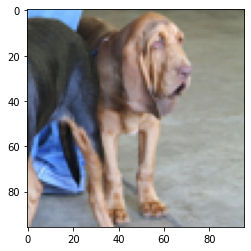

In [21]:

it,_ = next(iter(val_dataloader))
it_arr = it.numpy()
plt.imshow(it_arr[0].transpose(1,2,0))

print(torch.from_numpy(cv2.GaussianBlur(train_set_arr[i],(3,3),0).transpose(1,0,2)).float().div(255.0).shape)

Gaussian_blur_moderate_tr_arr = np.array([])
y = np.array([])
GS = cv2.GaussianBlur(train_set_arr[1],(3,3),0)
Gaussian_blur_moderate_tr_arr = np.append(Gaussian_blur_moderate_tr_arr,GS)
print(y.shape)
print(Gaussian_blur_moderate_tr_arr.shape)

print(type(GS))

print(Gaussian_blur_moderate_tr_arr.shape)

type(Gaussian_blur_moderate_tr_arr)

In [22]:
class DenosingAutoencoder(nn.Module):
  def __init__(self):
    super(DenosingAutoencoder, self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 2, stride = 2, padding=0),
    #48 by 48 by 32
        nn.ReLU(True),


        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2, padding = 0),
        nn.ReLU(True),
    # 24 by 24 by 64  

        nn.Conv2d(in_channels =64, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
    # 12 by 12 by 128 

        nn.ReLU(True),

        nn.Conv2d(in_channels = 128, out_channels = 256,  kernel_size = 2, stride = 2, padding=0),
    # 6 by 6 by 256
        nn.ReLU(True),
    )
    self.decoder = nn.Sequential(
 
        nn.ConvTranspose2d(in_channels = 256, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),
    # 12 by 12 by 128  
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),
    # 24 by 24 by 64

        nn.ConvTranspose2d(in_channels = 64, out_channels = 32,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),        
    # 48 by 48 by 32

        nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 2, stride = 2, padding=0),
    # 96 by 96 by 3
        nn.Sigmoid())
  
  def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


cuda
Epoch : [1/25] 

Training Loss: 0.016862	 validation Loss 0.007264
Epoch : [2/25] 

Training Loss: 0.014554	 validation Loss 0.007127
Epoch : [3/25] 

Training Loss: 0.014413	 validation Loss 0.007058
Epoch : [4/25] 

Training Loss: 0.014344	 validation Loss 0.007060
Epoch : [5/25] 

Training Loss: 0.014308	 validation Loss 0.007050
PNSR :21.30 	 SSIM : 0.61
PNSR :17.47 	 SSIM : 0.66
PNSR :7.38 	 SSIM : 0.42
PNSR :16.17 	 SSIM : 0.53
PNSR :20.25 	 SSIM : 0.88


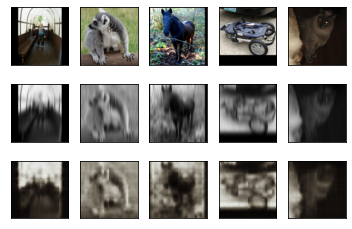

Epoch : [6/25] 

Training Loss: 0.014285	 validation Loss 0.007060
Epoch : [7/25] 

Training Loss: 0.014266	 validation Loss 0.007069
Epoch : [8/25] 

Training Loss: 0.014242	 validation Loss 0.007066
Epoch : [9/25] 

Training Loss: 0.014230	 validation Loss 0.007056
Epoch : [10/25] 

Training Loss: 0.014222	 validation Loss 0.007055
PNSR :22.38 	 SSIM : 0.62
PNSR :17.61 	 SSIM : 0.66
PNSR :7.41 	 SSIM : 0.42
PNSR :16.26 	 SSIM : 0.53
PNSR :20.45 	 SSIM : 0.88


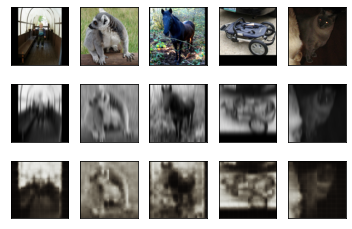

Epoch : [11/25] 

Training Loss: 0.014216	 validation Loss 0.007046
Epoch : [12/25] 

Training Loss: 0.014211	 validation Loss 0.007045
Epoch : [13/25] 

Training Loss: 0.014207	 validation Loss 0.007040
Epoch : [14/25] 

Training Loss: 0.014203	 validation Loss 0.007051
Epoch : [15/25] 

Training Loss: 0.014197	 validation Loss 0.007129
PNSR :22.02 	 SSIM : 0.62
PNSR :16.96 	 SSIM : 0.66
PNSR :7.24 	 SSIM : 0.42
PNSR :16.44 	 SSIM : 0.53
PNSR :19.57 	 SSIM : 0.88


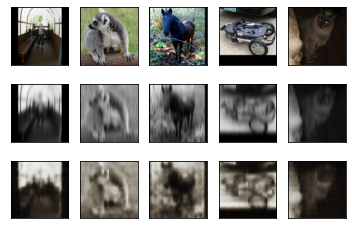

Epoch : [16/25] 

Training Loss: 0.014194	 validation Loss 0.007131
Epoch : [17/25] 

Training Loss: 0.014191	 validation Loss 0.007166
Epoch : [18/25] 

Training Loss: 0.014187	 validation Loss 0.007172
Epoch : [19/25] 

Training Loss: 0.014183	 validation Loss 0.007172
Epoch : [20/25] 

Training Loss: 0.014181	 validation Loss 0.007186
PNSR :22.10 	 SSIM : 0.62
PNSR :16.82 	 SSIM : 0.66
PNSR :7.20 	 SSIM : 0.42
PNSR :16.41 	 SSIM : 0.53
PNSR :19.35 	 SSIM : 0.88


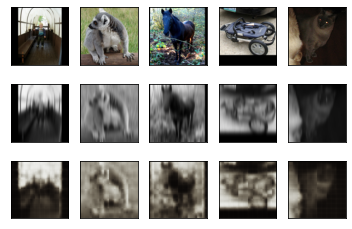

Epoch : [21/25] 

Training Loss: 0.014178	 validation Loss 0.007161
Epoch : [22/25] 

Training Loss: 0.014175	 validation Loss 0.007177
Epoch : [23/25] 

Training Loss: 0.014173	 validation Loss 0.007158
Epoch : [24/25] 

Training Loss: 0.014171	 validation Loss 0.007148
Epoch : [25/25] 

Training Loss: 0.014169	 validation Loss 0.007152
PNSR :22.32 	 SSIM : 0.62
PNSR :16.90 	 SSIM : 0.66
PNSR :7.18 	 SSIM : 0.42
PNSR :16.45 	 SSIM : 0.54
PNSR :19.38 	 SSIM : 0.88


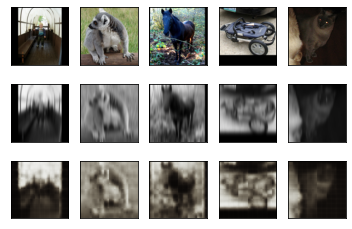

execution time : 32.5min


In [23]:
#Epochs
n_epochs = 25

device = get_device()
print(device)
model_moderate = DenosingAutoencoder()
optimizer_moderate = torch.optim.Adam(model_moderate.parameters(), lr=0.001, weight_decay  = 1e-04)
model_moderate=model_moderate.to(device)

moderate_train_loss_graph = np.array([])
moderate_val_loss_graph = np.array([])




start = time.time()

for epoch in range(1, n_epochs+1):
    print(f"Epoch : [{epoch}/{n_epochs}]","\n")
    model_moderate.train()
    # monitor training loss
    train_loss = 0.0
    total_train_loss = 0.0
    val_loss = 0.0
    total_val_loss = 0.0
    tr_dataloader_iter = iter(tr_dataloader)
    hat_tr_dataloader_iter = iter(Gs_blur_moderate_tr_dataloader)
    '''
    Total되는 새로운 변수를 하나 만들어줘야지 val_loss가 제대로 더해진다. 안 하면 이상하게 안 더해진다.
    '''
    #Training
    for i in range(len(tr_dataloader)):
        tr_images,_ = next(tr_dataloader_iter)
        tr_images = tr_images.to(device)
#        print(tr_images_arr.shape)
        hat_tr_images,_ = next(hat_tr_dataloader_iter)
#check   print(type(hat_tr_images))
        hat_tr_images = hat_tr_images.to(device)
#check   print(tr_images.shape)
        optimizer_moderate.zero_grad()
#check0. print(hat_tr_images.shape)  
        tr_outputs =model_moderate(hat_tr_images)
#check   print(tr_outputs.shape)
        loss = mse_loss(tr_outputs, tr_images)
        loss.backward()
        optimizer_moderate.step()
        train_loss = loss.item()
        total_train_loss += train_loss

#check1.        print(f"minibatch : {i}, train_loss_added : {total_train_loss/1250}")
    total_train_loss = total_train_loss/len(tr_dataloader)
    moderate_train_loss_graph = np.append(moderate_train_loss_graph, total_train_loss)


    #evaluation
    model_moderate.eval()

    with torch.no_grad():   
        optimizer_moderate.zero_grad()
        
        for i, (img, hat_img) in enumerate(zip(val_dataloader, Gs_blur_moderate_val_dataloader)):
                val_img, _ = img
                hat_val_img,_ = hat_img
                 
                val_img = val_img.to(device)
                hat_val_img = hat_val_img.to(device)
                val_outputs =model_moderate(hat_val_img)
#                print('val_outputs shape:',val_outputs.shape )
                val_loss = mse_loss(val_outputs, val_img)
                val_loss = val_loss.item()
                total_val_loss += val_loss
#check2.     print(f"val_mini_batch : {i }, val_loss_added : {total_val_loss/313}")                
        total_val_loss = total_val_loss/len(val_dataloader)
        moderate_val_loss_graph = np.append(moderate_val_loss_graph, total_val_loss)
        print('Training Loss: {:.6f}\t validation Loss {:.6f}'.format(total_train_loss, total_val_loss))
          
#check3.     
        if (epoch)%5 == 0:

          for j in range(5):
            val_ssim = ssim(val_img[j].cpu().detach().numpy().transpose(1, 2, 0), val_outputs[j].cpu().detach().numpy().transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
            val_psnr = Get_psnr(val_img[j], val_outputs[j], max_val = 1.0)
            print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))
            
            ax = plt.subplot(3,5,j+1)
            plt.imshow(val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3,5,j+5+1)
            plt.imshow(hat_val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3, 5, j+5+5+1)
            plt.imshow(val_outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

          plt.show()   

end = time.time()
total_time = (end-start)/60
print("execution time : {:.1f}min".format(total_time))

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
PATH1 = '/content/drive/MyDrive/model/model_moderate.pth'
torch.save(model_moderate.state_dict(), PATH1)

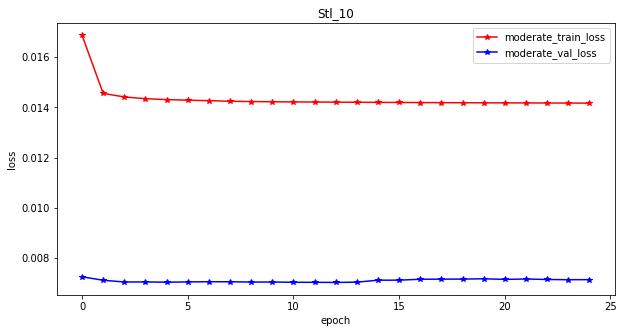

In [28]:
plt.figure(figsize=(10,5))
plt.plot(moderate_train_loss_graph,'r-*')
plt.plot(moderate_val_loss_graph, 'b-*')
plt.legend(['moderate_train_loss','moderate_val_loss'])
plt.title("Stl_10")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig('./moderate_loss_graph.png')


# moderate test

In [29]:

Gs_blur_moderate_test_dataset = []

for j in range(8000):
  hat_img_test_set_arr = cv2.GaussianBlur(img_test_set_arr[j], (21,21),0)
  hat_img_test_set_tensor_byte = torch.from_numpy(hat_img_test_set_arr)
  hat_img_test_set_tensor_float = hat_img_test_set_tensor_byte.float()
  hat_img_test_set_tensor_normal = hat_img_test_set_tensor_float.div(255.0)
  Gs_blur_moderate_test_dataset.append([hat_img_test_set_tensor_normal,0])

Gs_blur_moderate_test_dataloader = DataLoader(Gs_blur_moderate_test_dataset, batch_size = batch_size, num_workers = 4)

# moderate graph

# test graph for (average psnr, ssim)

PNSR :11.98 	 SSIM : 0.60
PNSR :12.45 	 SSIM : 0.60
PNSR :12.74 	 SSIM : 0.35
PNSR :18.00 	 SSIM : 0.70
PNSR :18.63 	 SSIM : 0.67
PNSR :14.23 	 SSIM : 0.81
PNSR :12.67 	 SSIM : 0.72
PNSR :11.06 	 SSIM : 0.54
PNSR :13.87 	 SSIM : 0.51
PNSR :13.85 	 SSIM : 0.69


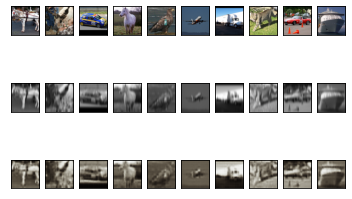

avg_psnr : 13.95
avg_ssim : 0.62


In [30]:
from skimage.metrics import structural_similarity as ssim

sum_ssim = 0.0
sum_psnr = 0.0
avg_ssim = 0.0
avg_psnr = 0.0

model_moderate.eval()
with torch.no_grad():
    optimizer_moderate.zero_grad()
    for i, (test_img, hat_test_img) in enumerate(zip(test_dataloader, Gs_blur_moderate_test_dataloader)):
        
        moderate_test_img, _ = test_img
        moderate_test_img = moderate_test_img.to(device)
        moderate_test_hat_img, _ = hat_test_img
        moderate_test_hat_img = moderate_test_hat_img.to(device)

        test_outputs = model_moderate(moderate_test_hat_img)
        
    for j in range(10):
        img1_cpu = moderate_test_img[j].cpu().numpy().transpose(1, 2, 0)
        img1_float64 = img1_cpu.astype(np.float64)
        img2_cpu = test_outputs[j].cpu().numpy()
        img2_float64 = img2_cpu.astype(np.float64).transpose(1, 2, 0)
        
        moderate_ssim = ssim(img1_float64, img2_float64, multichannel=True, gaussian_weights=True)
        moderate_psnr = Get_psnr(moderate_test_img[j], test_outputs[j], max_val = 1.0)
        sum_psnr+=moderate_psnr
        sum_ssim+=moderate_ssim
        print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(moderate_psnr,moderate_ssim))
        
        ax = plt.subplot(3,10,j+1)
        plt.imshow(moderate_test_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10,j+10+1)
        plt.imshow(moderate_test_hat_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10, j+20+1)
        plt.imshow(test_outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()   
avg_psnr=sum_psnr/10
avg_ssim=sum_ssim/10

print("avg_psnr : {:.2f}".format(avg_psnr))
print("avg_ssim : {:.2f}".format(avg_ssim))
